# Imports and setup 

### Ultralytics

In [1]:
# Pip install method (recommended)

# !pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
Setup complete ✅ (24 CPUs, 31.1 GB RAM, 103.2/878.6 GB disk)


### Set home directory

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/mnt/Storage/Licenta-main/Licenta


In [3]:
# %cd {HOME}
# !git clone https://github.com/ifzhang/ByteTrack.git
# %cd {HOME}/ByteTrack

# # workaround related to https://github.com/roboflow/notebooks/issues/80
# !sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

# !pip3 install -q -r requirements.txt
# !python3 setup.py -q develop
# !pip install -q cython_bbox
# !pip install -q onemetric
# # workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
# !pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


### ByteTracker

In [4]:
!git clone https://github.com/HanGuangXin/ByteTrack_ReID.git

fatal: destination path 'ByteTrack_ReID' already exists and is not an empty directory.


In [5]:
from ByteTrack_ReID.yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.5
    track_buffer: int = 50
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

### Supervision

In [6]:
# !pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [7]:
from supervision.draw.color import ColorPalette
from supervision.draw.color import Color
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

### Bytetracker setup

In [8]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

### Yolov8x setup

In [9]:
# settings
MODEL = "yolov8x.pt"

In [12]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


#### Test yolo

In [11]:
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source='https://cdn.theatlantic.com/media/mt/food/RTR2LP34edit.jpg'

^C
Traceback (most recent call last):
  File "/home/alex/.local/bin/yolo", line 5, in <module>
    from ultralytics.cfg import entrypoint
  File "/home/alex/.local/lib/python3.10/site-packages/ultralytics/__init__.py", line 5, in <module>
    from ultralytics.data.explorer.explorer import Explorer
  File "/home/alex/.local/lib/python3.10/site-packages/ultralytics/data/__init__.py", line 3, in <module>
    from .base import BaseDataset
  File "/home/alex/.local/lib/python3.10/site-packages/ultralytics/data/base.py", line 15, in <module>
    from torch.utils.data import Dataset
  File "/home/alex/.local/lib/python3.10/site-packages/torch/__init__.py", line 1854, in <module>
    from . import _meta_registrations
  File "/home/alex/.local/lib/python3.10/site-packages/torch/_meta_registrations.py", line 9, in <module>
    from torch._decomp import (
  File "/home/alex/.local/lib/python3.10/site-packages/torch/_decomp/__init__.py", line 243, in <module>
    import torch._decomp.decomposition

In [10]:
model.model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [13]:
SOURCE_VIDEO_PATH = "/mnt/Storage/Licenta-main/Videos/00001-converted.mp4"

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

print(f"SOURCE_VIDEO_PATH: {SOURCE_VIDEO_PATH}")
print(f"TARGET_VIDEO_PATH: {TARGET_VIDEO_PATH}")

VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

SOURCE_VIDEO_PATH: /mnt/Storage/Licenta-main/Videos/00001-converted.mp4
TARGET_VIDEO_PATH: /mnt/Storage/Licenta-main/Licenta/vehicle-counting-result.mp4


VideoInfo(width=1440, height=1080, fps=25, total_frames=2559)

In [14]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - person, car, motorcycle, bus and truck
CLASS_ID = [0, 2, 3, 5, 7]
CLASS_ID_PEOPLE = [0]
CLASS_ID_VEHICLE = [2, 3, 5, 7]

#### Select counting lines coodrinates

In [15]:
import cv2
import numpy as np

# Initialize global variables
points = []  # To store the points where you click
lines = []

# Callback function for mouse events
def click_event(event, x, y, flags, param):
    global points, img, scaleFactorX, scaleFactorY
    if event == cv2.EVENT_LBUTTONDOWN:  # Left button click
        if len(points) < 2:  # Ensure we only have 2 points
            # Adjust x, y back to original image scale
            origX = int(x * scaleFactorX)
            origY = int(y * scaleFactorY)
            points.append((origX, origY))
            cv2.circle(resized_img, (x, y), 5, (0, 0, 255), -1)  # Draw the dot on resized image
            if len(points) == 2:
                lines.append((points[0], points[1]))
                cv2.line(resized_img, 
                    (int(points[0][0] // scaleFactorX), int(points[0][1] // scaleFactorY)),
                    (int(points[1][0] // scaleFactorX), int(points[1][1] // scaleFactorY)), 
                    (255, 0, 0), 2)  # Draw the line on resized image
                print(f"Point 1: {points[0]}, Point 2: {points[1]}")  # Print coordinates of original points
                cv2.imshow("image", resized_img)  # Show the image with the line
                
    if len(points) == 2:  # Reset after 2 points for new line drawing
        points.clear()



# Create a black image
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# Resize the image to 200x200
resized_img = cv2.resize(frame, (1000, 800))

# Calculate scale factors
originalHeight, originalWidth = frame.shape[:2]
scaleFactorX = originalWidth / 1000
scaleFactorY = originalHeight / 800

cv2.namedWindow("image")
cv2.setMouseCallback("image", click_event)

cv2.imshow("image", resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

line_start = Point(lines[0][0][0], lines[0][0][1])
line_end = Point(lines[0][1][0], lines[0][1][1])

line_cars_start = Point(lines[1][0][0], lines[1][0][1])
line_cars_end = Point(lines[1][1][0], lines[1][1][1])

print(f"line_start: {line_start}, line_end: {line_end}")
print(f"line_cars_start: {line_cars_start}, line_cars_end: {line_cars_end}")

Point 1: (135, 707), Point 2: (1241, 768)
Point 1: (656, 1), Point 2: (812, 1073)
line_start: Point(x=135, y=707), line_end: Point(x=1241, y=768)
line_cars_start: Point(x=656, y=1), line_cars_end: Point(x=812, y=1073)


### Predict

In [16]:
# Override the update function from line_counter.py

from supervision.tools.line_counter import LineCounter

class LineCounter(LineCounter):
    def update(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        :param detections: Detections : The detections for which to update the counts.
        """
        for xyxy, confidence, class_id, tracker_id in detections:
            # If there is no tracker_id, we skip the detection
            if tracker_id is None:
                continue

            # See how many points are on each side of the line
            x1, y1, x2, y2 = xyxy
            # anchors = [
            #     Point(x=x1, y=y1),
            #     Point(x=x1, y=y2),
            #     Point(x=x2, y=y1),
            #     Point(x=x2, y=y2),
            # ]

            # Workaround for the fact that the bboxes are too big

            '''
                Introduce a padding so the bbox will be the one in the interior of the original one, like so:
                |-----------------------|
                |  \                  / |
                |   \---------------/   |
                |   |Bbox w padding |   |
                |   /---------------\   |
                | /                  \  |
                |-----------------------|
            
            '''
            # Preduce the box by 40% of its original size
            percentange = 0.3
            anchors = [
                Point(x=x1 + (x2 - x1) * percentange, y=y1 + (y2 - y1) * percentange),
                Point(x=x1 + (x2 - x1) * percentange, y=y2 - (y2 - y1) * percentange),
                Point(x=x2 - (x2 - x1) * percentange, y=y1 + (y2 - y1) * percentange),
                Point(x=x2 - (x2 - x1) * percentange, y=y2 - (y2 - y1) * percentange),
            ]


            # Bool list. The truth value indicates the side of the line the point is on.
            triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

            # detection is partially in and partially out
            if len(set(triggers)) == 2:
                continue

            tracker_state = triggers[0]
            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if tracker_state:
                self.in_count += 1
            else:
                self.out_count += 1

In [32]:
from tqdm.notebook import tqdm
import cv2


def annotate_with_counts(frame, people_count, vehicles_count, font_scale=1, thickness=2):
    # Set the position for the annotations on the frame
    position_people = (10, 30)
    position_vehicles = (10, 60)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f"People crossed: {people_count}", position_people, font, font_scale, (255, 255, 0), thickness)
    cv2.putText(frame, f"Vehicles crossed: {vehicles_count}", position_vehicles, font, font_scale, (0, 255, 0), thickness)


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(AUX_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(AUX_VIDEO_PATH)
# create LineCounter instance
line_counter_people = LineCounter(start=line_start, end=line_end)
line_counter_vehicles = LineCounter(start=line_cars_start, end=line_cars_end)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator_people = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)
line_annotator_vehicle = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2, color=Color(0, 255, 0))

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_people = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_vehicles = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask_people = np.array([class_id in CLASS_ID_PEOPLE for class_id in detections.class_id], dtype=bool)
        mask_vehicle = np.array([class_id in CLASS_ID_VEHICLE for class_id in detections.class_id], dtype=bool)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicle, inplace=True)
        print("DEBUG", len(detections_people.class_id))
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks_people = byte_tracker.update(
            output_results=detections2boxes(detections=detections_people),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks_vehicles = byte_tracker.update(
            output_results=detections2boxes(detections=detections_vehicles),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        tracker_id_people = match_detections_with_tracks(detections=detections_people, tracks=tracks_people)
        tracker_id_vehicles = match_detections_with_tracks(detections=detections_vehicles, tracks=tracks_vehicles)
        detections.tracker_id = np.array(tracker_id)
        detections_people.tracker_id = np.array(tracker_id_people)
        detections_vehicles.tracker_id = np.array(tracker_id_vehicles)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        mask_people = np.array([tracker_id is not None for tracker_id in detections_people.tracker_id], dtype=bool)
        mask_vehicles = np.array([tracker_id is not None for tracker_id in detections_vehicles.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicles, inplace=True)
        
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]

        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        # updating line counter
        line_counter_people.update(detections=detections_people)
        line_counter_vehicles.update(detections=detections_vehicles)
        # annotate and display frame
        line_annotator_people.annotate(frame=frame, line_counter=line_counter_people)
        line_annotator_vehicle.annotate(frame=frame, line_counter=line_counter_vehicles)
        # Display number of cars that crossed the line and number of people that crossed the line in the left corner of the frame

        annotate_with_counts(frame, line_counter_people.in_count + line_counter_people.out_count, line_counter_vehicles.in_count + line_counter_vehicles.out_count)

        sink.write_frame(frame)

  0%|          | 0/1230 [00:00<?, ?it/s]


0: 480x640 14 persons, 6 cars, 2 traffic lights, 1 stop sign, 1 suitcase, 36.7ms
Speed: 10.5ms preprocess, 36.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 14

0: 480x640 15 persons, 6 cars, 1 traffic light, 1 stop sign, 1 suitcase, 35.6ms
Speed: 1.2ms preprocess, 35.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 15

0: 480x640 14 persons, 6 cars, 1 traffic light, 1 stop sign, 35.9ms
Speed: 1.2ms preprocess, 35.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 14

0: 480x640 13 persons, 7 cars, 2 traffic lights, 1 stop sign, 34.9ms
Speed: 1.2ms preprocess, 34.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 13

0: 480x640 16 persons, 8 cars, 1 traffic light, 1 stop sign, 34.4ms
Speed: 1.3ms preprocess, 34.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 16

0: 480x640 16 persons, 7 cars, 2 traffic lights, 1 stop sign, 33.6ms
Speed: 1.2ms preprocess, 33.

### Identify the traffic lights and see what colour they are

In [31]:
# !pip install ffmpeg-python
import ffmpeg

AUX_VIDEO_PATH = f"{HOME}/auxi.mp4"

(
	ffmpeg.input(SOURCE_VIDEO_PATH)
    .filter('fps', fps=12) # TODO: change to 12
	.output(AUX_VIDEO_PATH)
	.run(overwrite_output=True)
)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

(None, None)

In [17]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1440, height=1080, fps=25, total_frames=1753)

In [19]:
!pip install traffic_light_classifier

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 5.6 MB/s eta 0:00:0000:0100:01m


In [17]:
import cv2
import numpy as np

def predict_traffic_light_color(frame):
    # Convert to HSV color space
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Define hue ranges for red, yellow, and green (these ranges might need adjustment)
    red_lower1 = np.array([0, 100, 100])
    red_upper1 = np.array([160, 100, 100])
    red_lower2 = np.array([160, 50, 50])
    red_upper2 = np.array([180, 255, 255])
    yellow_lower = np.array([20, 50, 50])
    yellow_upper = np.array([30, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([90, 255, 255])
    # Count pixels within each color range
    red_pixels = (cv2.inRange(hsv, red_lower1, red_upper1) > 0).sum() + (cv2.inRange(hsv, red_lower2, red_upper2) > 0).sum()
    yellow_pixels = (cv2.inRange(hsv, yellow_lower, yellow_upper) > 0).sum()
    green_pixels = (cv2.inRange(hsv, green_lower, green_upper) > 0).sum()
    # Determine the most prominent color
    print(f"red_pixels: {red_pixels}, yellow_pixels: {yellow_pixels}, green_pixels: {green_pixels}")
    if red_pixels <= 30 and yellow_pixels <= 30 and green_pixels <= 30:
        return "Unknown"
    if max(red_pixels, yellow_pixels, green_pixels) == red_pixels:
        return "Red"
    elif max(red_pixels, yellow_pixels, green_pixels) == yellow_pixels:
        return "Yellow"
    else:
        return "Green"


In [18]:
import traffic_light_classifier as tlc


model_traffic_light = tlc.Model()
model_traffic_light.compile()


Importing package 'traffic_light_classifier'...
  + Adding module 'helpers'...
  - Done!
  + Adding module 'tests'...
  - Done!
  + Adding module 'plots'...
  - Done!
  + Adding module 'modify_images'...
  - Done!
  + Adding module 'extract_feature'...
  - Done!
  + Adding module 'statistics'...
  - Done!
  + Adding module 'datasets'...
  - Done!
  + Adding module 'model'...
  - Done!
Package 'traffic_light_classifier' imported sucessfully !!
version 1.0.0


Compilation in progress... Please wait !!


#### <span style='color: green;'>Compilation complete !!</span>

In [19]:
CLASS_ID_TRAFFIC_LIGHT = [9]


0: 480x640 18 persons, 6 cars, 2 traffic lights, 1 stop sign, 1 backpack, 1 suitcase, 30.8ms
Speed: 5.2ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


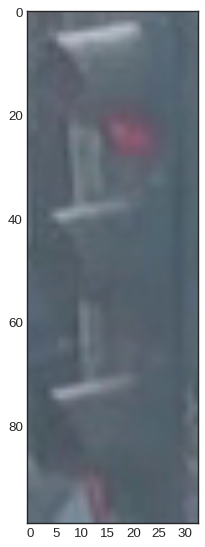

red_pixels: 24, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible


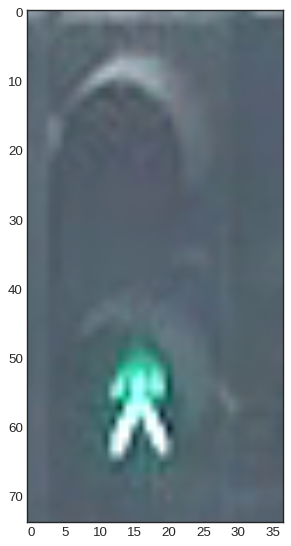

red_pixels: 0, yellow_pixels: 0, green_pixels: 105
Traffic light color: Green


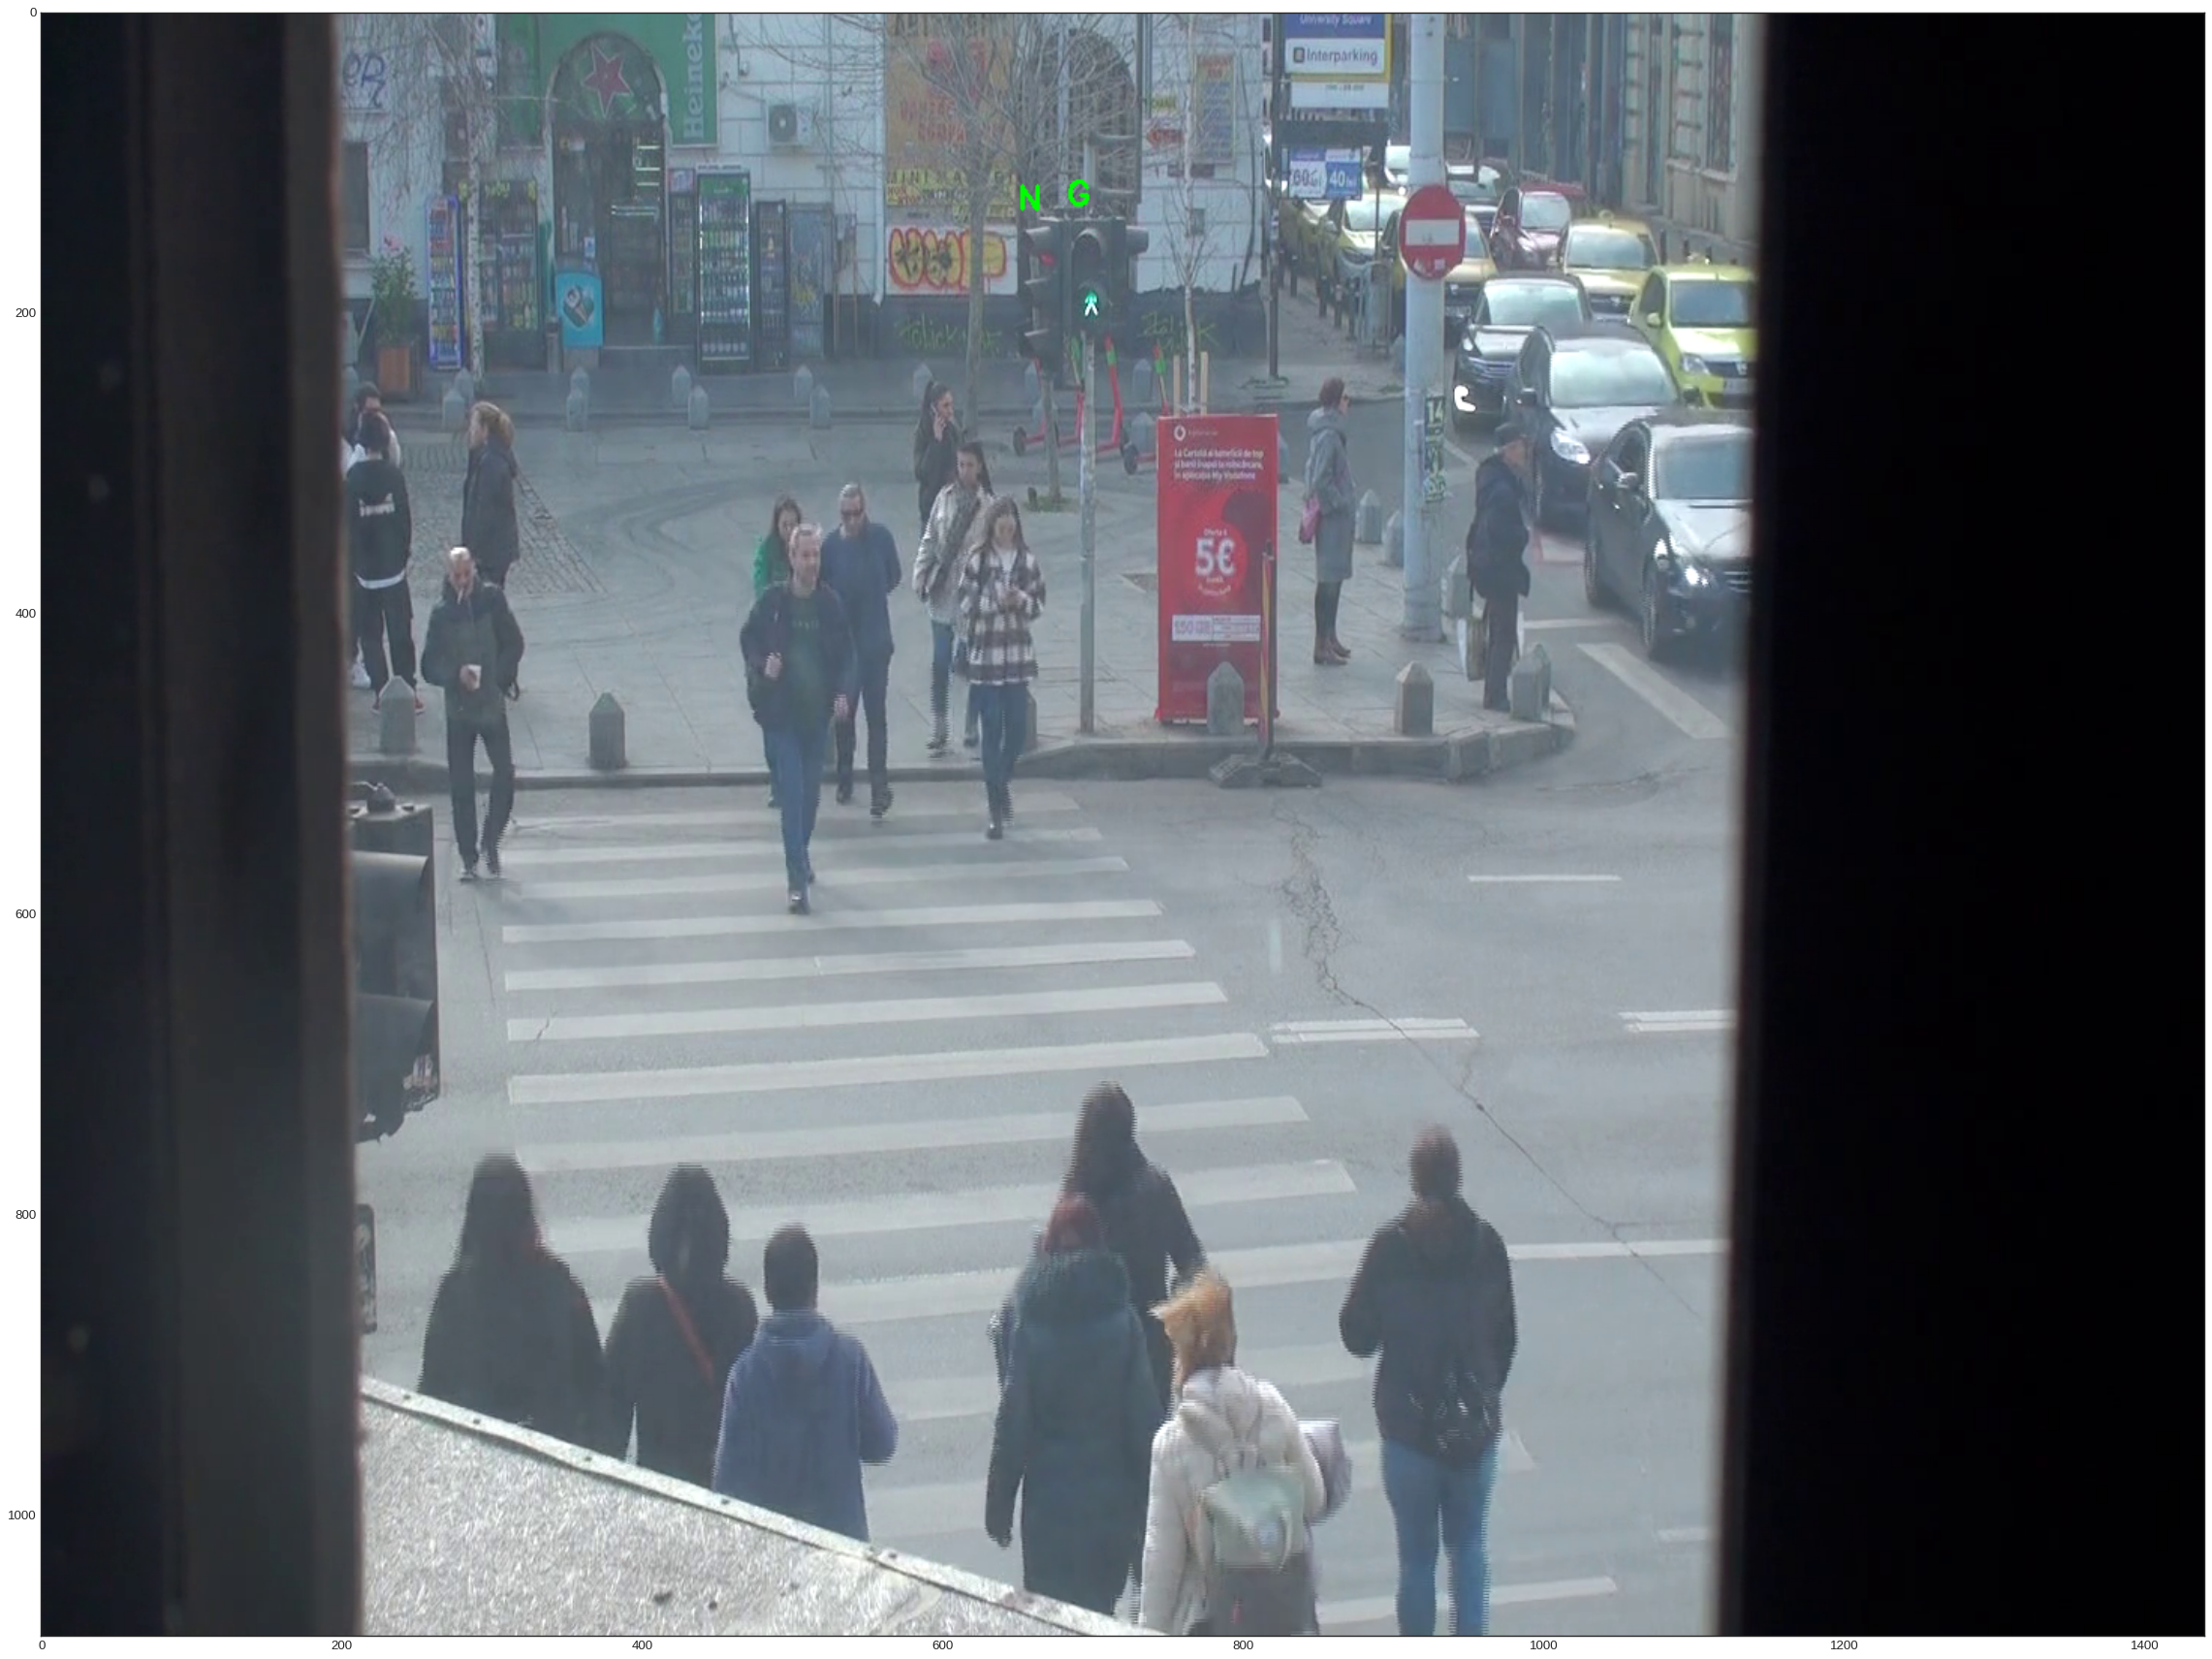

In [23]:
# create frame generator
from numpy import argmax


generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette())
# acquire first video frame
iterator = iter(generator)
# get the 500th frame
for _ in range(1500):
    frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

# filtering out detections with unwanted classes
mask_traffic_light= np.array([class_id in CLASS_ID_TRAFFIC_LIGHT for class_id in detections.class_id], dtype=bool)
detections.filter(mask=mask_traffic_light, inplace=True)

# Cut the box around the traffic light
for detection in detections.xyxy:
    %matplotlib inline
    x1, y1, x2, y2 = detection.astype(int)
    frame1 = frame[y1:y2, x1:x2]
    show_frame_in_notebook(frame1, (8, 8))

    # TODO: predict the color of the traffic light
    colours = ["Red", "Yellow", "Green"]
    color = predict_traffic_light_color(frame1)
    traffic_light_color = "Unknown"
    # print(f"Traffic light color: {color}")
    if color != "Unknown":
        frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
        pred = model_traffic_light.predict(frame1)
        if colours[argmax(pred)] != color:
            print(f"!!! hsv: {color}, nn: {colours[argmax(pred)]}")
            print(f"Traffic light color: {color}")
            traffic_light_color = color
        else:
            print(f"Traffic light color: {colours[argmax(pred)]}")
            traffic_light_color = colours[argmax(pred)]
    else:
        print("Traffic light color: not visible")
        traffic_light_color = "Not visible"

    text_position = (x1, y1 - 10 if y1 - 10 > 0 else y1 + 20)
    font_scale = 0.7  
    thickness = 2  
    cv2.putText(frame, traffic_light_color[0], text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

show_frame_in_notebook(frame, (36, 36))


In [44]:
from tqdm.notebook import tqdm
import cv2

# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        
        # filtering out detections with unwanted classes
        mask_traffic_light= np.array([class_id in CLASS_ID_TRAFFIC_LIGHT for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask_traffic_light, inplace=True)

        # Cut the box around the traffic light
        for detection in detections.xyxy:
            %matplotlib inline
            x1, y1, x2, y2 = detection.astype(int)
            frame1 = frame[y1:y2, x1:x2]


            # Predict the color of the traffic light
            colours = ["Red", "Yellow", "Green"]
            color = predict_traffic_light_color(frame1)
            traffic_light_color = "Unknown"
            # print(f"Traffic light color: {color}")
            if color != "Unknown":
                frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
                frame1 = cv2.resize(frame1, (32, 32))
                if frame1.size == 0:
                    raise ValueError("The cropped image is empty.")
                pred = model_traffic_light.predict(frame1, show_analysis=False)
                print(f"pred: {pred}")
                if colours[argmax(pred)] != color:
                    print(f"!!! hsv: {color}, nn: {colours[argmax(pred)]}")
                print(f"Traffic light color: {colours[argmax(pred)]}")
                traffic_light_color = colours[argmax(pred)]
            else:
                print("Traffic light color: not visible")
                traffic_light_color = "Not visible"

            text_position = (x1, y1 - 10 if y1 - 10 > 0 else y1 + 20)
            font_scale = 0.7  
            thickness = 2
            cv2.putText(frame, traffic_light_color[0], text_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

        sink.write_frame(frame)

  0%|          | 0/2559 [00:00<?, ?it/s]

0: 480x640 15 persons, 6 cars, 2 traffic lights, 1 stop sign, 33.9ms
Speed: 13.3ms preprocess, 33.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
red_pixels: 175, yellow_pixels: 0, green_pixels: 4
pred: [1, 0, 0]
Traffic light color: Red
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible

0: 480x640 16 persons, 6 cars, 2 traffic lights, 1 stop sign, 1 suitcase, 33.3ms
Speed: 1.2ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)
red_pixels: 176, yellow_pixels: 0, green_pixels: 0
pred: [1, 0, 0]
Traffic light color: Red
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible

0: 480x640 15 persons, 6 cars, 1 traffic light, 1 stop sign, 1 suitcase, 33.0ms
Speed: 1.1ms preprocess, 33.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
red_pixels: 161, yellow_pixels: 0, green_pixels: 0
pred: [1, 0, 0]
Traffic light color: Red

0: 480x640 16 persons, 6 cars, 2 tr

# Corelate the two algorithms

- Count only the pedestrians that cross on red colour
- Count only the cars that cross the zebra on green colour for pedestrians

In [64]:
from tqdm.notebook import tqdm
import cv2
from numpy import argmax
from datetime import timedelta
import pandas as pd


def annotate_with_counts(frame, time, people_count_green, vehicles_count_green, people_count_red, vehicles_count_red, font_scale=1, thickness=2):
    # Set the position for the annotations on the frame
    position_people_green = (10, 30)
    position_vehicles_green = (10, 60)
    position_people_red = (1000, 30)
    position_vehicles_red = (1000, 60)
    position_fps = (10, 90) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f"People crossed on green: {people_count_green}", position_people_green, font, font_scale, (255, 255, 0), thickness)
    cv2.putText(frame, f"Vehicles crossed on green: {vehicles_count_green}", position_vehicles_green, font, font_scale, (0, 255, 0), thickness)
    cv2.putText(frame, f"People crossed on red: {people_count_red}", position_people_red, font, font_scale, (0, 255, 255), thickness)
    cv2.putText(frame, f"Vehicles crossed on red: {vehicles_count_red}", position_vehicles_red, font, font_scale, (255, 0, 255), thickness)
    cv2.putText(frame, f"Timestamp: {time}", position_fps, font, font_scale, (255, 255, 255), thickness)



# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter_people = LineCounter(start=line_start, end=line_end)
line_counter_vehicles = LineCounter(start=line_cars_start, end=line_cars_end)
line_counter_people_green = LineCounter(start=line_start, end=line_end)
line_counter_people_red = LineCounter(start=line_start, end=line_end)
line_counter_vehicles_green = LineCounter(start=line_cars_start, end=line_cars_end)
line_counter_vehicles_red = LineCounter(start=line_cars_start, end=line_cars_end)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=3, text_thickness=4, text_scale=2)
line_annotator_people = LineCounterAnnotator(thickness=3, text_thickness=4, text_scale=1)
line_annotator_vehicle = LineCounterAnnotator(thickness=3, text_thickness=4, text_scale=1, color=Color(0, 255, 0))


# Timestamps for each frame
cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"fps: {fps}")
timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
calc_timestamps = [0.0]
while(cap.isOpened()):
    frame_exists, curr_frame = cap.read()
    if frame_exists:
        timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))
        calc_timestamps.append(calc_timestamps[-1] + 1000/fps)
    else:
        break
cap.release()
frame_time_stamp = dict()
for i, (ts, cts) in enumerate(zip(timestamps, calc_timestamps)):
    if i not in frame_time_stamp:
        frame_time_stamp[i] = (timedelta(milliseconds=ts), ts)

statistics = pd.DataFrame(columns=["Frame Nr", "Timestamp", "People crossed on green", "Vehicles crossed on green", "People crossed on red", "Vehicles crossed on red", 
                                   "Traffic light color"])

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame_nr, frame in enumerate(tqdm(generator, total=video_info.total_frames), start=1):        # model prediction on single frame and conversion to supervision Detections
        # model prediction on single frame and conversion to supervision Detections
        time = frame_time_stamp[frame_nr]
        print(f"time: {time}")
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_people = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_vehicles = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        detections_traffic_light = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask_people = np.array([class_id in CLASS_ID_PEOPLE for class_id in detections.class_id], dtype=bool)
        mask_vehicle = np.array([class_id in CLASS_ID_VEHICLE for class_id in detections.class_id], dtype=bool)
        mask_traffic_light= np.array([class_id in CLASS_ID_TRAFFIC_LIGHT for class_id in detections.class_id], dtype=bool)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicle, inplace=True)
        detections_traffic_light.filter(mask=mask_traffic_light, inplace=True)
        print("DEBUG", len(detections_people.class_id))
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks_people = byte_tracker.update(
            output_results=detections2boxes(detections=detections_people),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks_vehicles = byte_tracker.update(
            output_results=detections2boxes(detections=detections_vehicles),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        tracker_id_people = match_detections_with_tracks(detections=detections_people, tracks=tracks_people)
        tracker_id_vehicles = match_detections_with_tracks(detections=detections_vehicles, tracks=tracks_vehicles)
        detections.tracker_id = np.array(tracker_id)
        detections_people.tracker_id = np.array(tracker_id_people)
        detections_vehicles.tracker_id = np.array(tracker_id_vehicles)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        mask_people = np.array([tracker_id is not None for tracker_id in detections_people.tracker_id], dtype=bool)
        mask_vehicles = np.array([tracker_id is not None for tracker_id in detections_vehicles.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        detections_people.filter(mask=mask_people, inplace=True)
        detections_vehicles.filter(mask=mask_vehicles, inplace=True)

        traffic_light_color = "Unknown"
        # Cut the box around the traffic light
        for detection in detections_traffic_light.xyxy:
            %matplotlib inline
            x1, y1, x2, y2 = detection.astype(int)
            frame1 = frame[y1:y2, x1:x2]


            # Predict the color of the traffic light
            colours = ["Red", "Yellow", "Green"]
            color = predict_traffic_light_color(frame1)
            # print(f"Traffic light color: {color}")
            if color != "Unknown":
                frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
                frame1 = cv2.resize(frame1, (32, 32))
                if frame1.size == 0:
                    raise ValueError("The cropped image is empty.")
                pred = model_traffic_light.predict(frame1, show_analysis=False)
                print(f"pred: {pred}")
                if colours[argmax(pred)] != color:
                    print(f"!!! hsv: {color}, nn: {colours[argmax(pred)]}")
                print(f"Traffic light color: {colours[argmax(pred)]}")
                traffic_light_color = colours[argmax(pred)]
            else:
                print("Traffic light color: not visible")

        # updating line counter if the traffic light is green
        if traffic_light_color == "Green":
            line_counter_people_green.update(detections=detections_people)
            line_counter_vehicles_red.update(detections=detections_vehicles)
        elif traffic_light_color == "Red":
            line_counter_people_red.update(detections=detections_people)
            line_counter_vehicles_green.update(detections=detections_vehicles)

        line_counter_people.update(detections=detections_people)
        line_counter_vehicles.update(detections=detections_vehicles)


        # annotate and display frame
        line_annotator_people.annotate(frame=frame, line_counter=line_counter_people)
        line_annotator_vehicle.annotate(frame=frame, line_counter=line_counter_vehicles)
        # Update the statistics dataframe
        new_df = pd.DataFrame([[frame_nr, time[1], line_counter_people_green.in_count + line_counter_people_green.out_count,
                                line_counter_vehicles_green.in_count + line_counter_vehicles_green.out_count,
                                line_counter_people_red.in_count + line_counter_people_red.out_count,
                                line_counter_vehicles_red.in_count + line_counter_vehicles_red.out_count,
                                traffic_light_color]], columns=statistics.columns)
        statistics = pd.concat([statistics, new_df], ignore_index=True)
        annotate_with_counts(frame, time[0], line_counter_people_green.in_count + line_counter_people_green.out_count, 
                             line_counter_vehicles_green.in_count + line_counter_vehicles_green.out_count, 
                             line_counter_people_red.in_count + line_counter_people_red.out_count, 
                             line_counter_vehicles_red.in_count + line_counter_vehicles_red.out_count)
        sink.write_frame(frame)

fps: 25.009773260359655


  0%|          | 0/2559 [00:00<?, ?it/s]

time: (datetime.timedelta(microseconds=40000), 40.0)

0: 480x640 15 persons, 6 cars, 2 traffic lights, 1 stop sign, 33.9ms
Speed: 9.6ms preprocess, 33.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 15
red_pixels: 175, yellow_pixels: 0, green_pixels: 4
pred: [1, 0, 0]
Traffic light color: Red
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible
time: (datetime.timedelta(microseconds=80000), 80.0)

0: 480x640 16 persons, 6 cars, 2 traffic lights, 1 stop sign, 1 suitcase, 33.2ms
Speed: 1.8ms preprocess, 33.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 16
red_pixels: 176, yellow_pixels: 0, green_pixels: 0
pred: [1, 0, 0]
Traffic light color: Red
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible
time: (datetime.timedelta(microseconds=120000), 120.0)

0: 480x640 15 persons, 6 cars, 1 traffic light, 1 stop sign, 1 suitcase, 33.8ms
Speed: 1.2ms preprocess, 33.8ms inference, 1.1

/tmp/ipykernel_3123/1595104110.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  statistics = pd.concat([statistics, new_df], ignore_index=True)


red_pixels: 161, yellow_pixels: 0, green_pixels: 0
pred: [1, 0, 0]
Traffic light color: Red
time: (datetime.timedelta(microseconds=240000), 240.0)

0: 480x640 13 persons, 8 cars, 2 traffic lights, 1 stop sign, 1 suitcase, 32.1ms
Speed: 1.4ms preprocess, 32.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 13
red_pixels: 169, yellow_pixels: 0, green_pixels: 0
pred: [1, 0, 0]
Traffic light color: Red
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible
time: (datetime.timedelta(microseconds=280000), 279.99999999999994)

0: 480x640 13 persons, 7 cars, 3 traffic lights, 1 stop sign, 32.2ms
Speed: 1.2ms preprocess, 32.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
DEBUG 13
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not visible
red_pixels: 168, yellow_pixels: 0, green_pixels: 0
pred: [1, 0, 0]
Traffic light color: Red
red_pixels: 0, yellow_pixels: 0, green_pixels: 0
Traffic light color: not

In [76]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=statistics["Timestamp"]/60000, y=statistics["People crossed on green"], mode='lines', name='People crossed on green'))
fig.add_trace(go.Scatter(x=statistics["Timestamp"]/60000, y=statistics["Vehicles crossed on green"], mode='lines', name='Vehicles crossed on green'))

fig.update_layout(
    title="People and vehicles crossed on green",
    xaxis_title="Timestamp (minutes)",
    yaxis_title="Count",
    xaxis=dict(
        range=[statistics["Timestamp"].min()/60000, statistics["Timestamp"].max()/60000]
    )
)

fig.show()

fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=statistics["Timestamp"]/60000, y=statistics["People crossed on red"], mode='lines', name='People crossed on red'))
fig2.add_trace(go.Scatter(x=statistics["Timestamp"]/60000, y=statistics["Vehicles crossed on red"], mode='lines', name='Vehicles crossed on red'))

fig2.update_layout(
    title="People and vehicles crossed on red",
    xaxis_title="Timestamp (minutes)",
    yaxis_title="Count",
    xaxis=dict(
        range=[statistics["Timestamp"].min()/60000, statistics["Timestamp"].max()/60000]
    )
)

fig2.show()

fig3 = go.Figure()

fig3.add_trace(go.Scatter(x=statistics["Timestamp"]/60000, y=statistics["Traffic light color"], mode='lines', name='Traffic light color'))

fig3.update_layout(
    title="Traffic light color",
    xaxis_title="Timestamp (minutes)",
    yaxis_title="Color",
    xaxis=dict(
        range=[statistics["Timestamp"].min()/60000, statistics["Timestamp"].max()/60000]
    )
)

fig3.show()


